In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_fscore_support

Weights were used for EDA; this variant of modeling is unweighted to optimize predictive performance.

In [2]:
#load the preprocessed data
data= pd.read_csv("final_data.csv")
print(data.shape)
data.head()

(199523, 42)


,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veterans_admin,veterans_benefits,weeks_worked_in_year,year,label
0,73,Not_in_universe,0,0,High school graduate,0,Not_in_universe,Widowed,Not in universe or children,Not_in_universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not_in_universe,2,0,1995,0
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not_in_universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not_in_universe,2,52,1994,0
2,18,Not_in_universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not_in_universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not_in_universe,2,0,1995,0
3,9,Not_in_universe,0,0,Children,0,Not_in_universe,Never married,Not in universe or children,Not_in_universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not_in_universe,0,0,1994,0
4,10,Not_in_universe,0,0,Children,0,Not_in_universe,Never married,Not in universe or children,Not_in_universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not_in_universe,0,0,1994,0


We are looking into variables that have multicollinearity/ weak relationships/ unclear semantics that can be removed for modeling. 

In [3]:
import pandas as pd
import numpy as np

# assumes you already loaded final_data.csv into `data`
num_cols = data.select_dtypes(include=[np.number]).columns.tolist()

# remove target & weight if present
for col in ["label", "weight"]:
    if col in num_cols:
        num_cols.remove(col)

pearson_corr = data[num_cols].corr(method="pearson")
spearman_corr = data[num_cols].corr(method="spearman")

# show strongest absolute correlations (excluding self-corr)
def top_corr_pairs(corr_matrix, top_n=30):
    c = corr_matrix.abs().where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    pairs = c.stack().sort_values(ascending=False).head(top_n)
    return pairs

print("Top Pearson pairs:")
display(top_corr_pairs(pearson_corr, 25))

print("Top Spearman pairs:")
display(top_corr_pairs(spearman_corr, 25))


Top Pearson pairs:


detailed_industry_recode         weeks_worked_in_year               0.754472
num_persons_worked_for_employer  weeks_worked_in_year               0.747302
age                              veterans_benefits                  0.674844
detailed_occupation_recode       weeks_worked_in_year               0.655613
detailed_industry_recode         num_persons_worked_for_employer    0.642096
                                 detailed_occupation_recode         0.563493
veterans_benefits                weeks_worked_in_year               0.532279
detailed_occupation_recode       num_persons_worked_for_employer    0.515554
detailed_industry_recode         veterans_benefits                  0.476475
num_persons_worked_for_employer  veterans_benefits                  0.463334
detailed_occupation_recode       veterans_benefits                  0.438680
own_business_or_self_employed    weeks_worked_in_year               0.265872
detailed_industry_recode         own_business_or_self_employed      0.252694

Top Spearman pairs:


num_persons_worked_for_employer  weeks_worked_in_year               0.880982
detailed_industry_recode         weeks_worked_in_year               0.817527
                                 detailed_occupation_recode         0.807056
detailed_occupation_recode       weeks_worked_in_year               0.794553
detailed_industry_recode         num_persons_worked_for_employer    0.769482
detailed_occupation_recode       num_persons_worked_for_employer    0.738711
age                              veterans_benefits                  0.714068
veterans_benefits                weeks_worked_in_year               0.546476
num_persons_worked_for_employer  veterans_benefits                  0.535047
detailed_industry_recode         veterans_benefits                  0.514147
detailed_occupation_recode       veterans_benefits                  0.514060
age                              weeks_worked_in_year               0.286899
num_persons_worked_for_employer  own_business_or_self_employed      0.283548

#### Correlations:

**We look into the Pearson correlations (linear), Spearman correlations (rank / monotonic)**

1. High correlation with detailed codes. **Detailed industry recode** and **detailed occupation recode** are already captured better by:
- weeks_worked_in_year
- wage_per_hour
- major_occupation_code
- major_industry_code

So we remove the Detailed industry recode and detailed occupation recode.

2. **num_persons_worked_for_employer** and **weeks_worked_in_year**
- Spearman ≈ 0.88 (very high), Pearson = 0.75
- This variable is essentially encoding employment intensity / job continuity, which weeks_worked_in_year already captures directly and more clearly.
- So we drop num_persons_worked_for_employer and keep weeks_worked_in_year.

3. **age** and **veterans_benefits**
- Pearson = 0.67, Spearman = 0.71
- Also correlated with weeks_worked_in_year
- We can exclude Veterans benefits as they largely proxy age and labor-force status rather than independent income drivers.

4. **Own business or self employed**
Correlations:
- Moderate with weeks worked (~0.26)
- Moderate with detailed industry/occupation
- Weak standalone relationships
- Overlaps with: class_of_worker, major_occupation_code
- We drop this variable


Based on EDA, understanding of business and correlations, here are final 19 variables for modeling:

- age
- sex
- race
- hispanic_origin
- citizenship
- education
- marital_stat
- tax_filer_stat
- family_members_under_18 (It captures Household dependency burden which is proxy for: single-earner households, childcare responsibilities, income dilution. 
Also the evidence from EDA shows: more dependents → lower probability of >$50K)
- class_of_worker
- major_occupation_code
- major_industry_code
- full_or_part_time_employment_stat
- weeks_worked_in_year
- wage_per_hour
- capital_gains
- capital_losses
- dividends_from_stocks
- year



In [ ]:
REDUCED_FEATURES = [
    "age", "sex", "race", "hispanic_origin", "citizenship",
    "education",
    "class_of_worker", "major_occupation_code", "major_industry_code",
    "full_or_part_time_employment_stat",
    "weeks_worked_in_year", "wage_per_hour",
    "marital_stat", "family_members_under_18", "tax_filer_stat",
    "capital_gains", "capital_losses", "dividends_from_stocks",
    "year"
]

X = data[REDUCED_FEATURES]
y = data["label"]

In [5]:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

print("Numeric:", len(num_cols))
print("Categorical:", len(cat_cols))

Numeric: 7
Categorical: 12


In [8]:
# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [9]:
#Preprocessing pipeline

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)


#### 1. Baseline Model: Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression

log_reg = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", LogisticRegression(
            max_iter=1000,
            class_weight="balanced",   # handles imbalance
            n_jobs=-1
        ))
    ]
)

In [11]:
log_reg.fit(X_train, y_train)

/Users/amulyajayanti/Downloads/TakeHomeProject/jpmcenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

Categorical variables are one-hot encoded, and numeric variables are standardized using z-score normalization. All preprocessing steps were implemented within a unified pipeline to prevent data leakage and ensure consistent transformation across training and validation data.

#### 2. Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", RandomForestClassifier(
            n_estimators=300,
            max_depth=None,
            min_samples_leaf=50,
            n_jobs=-1,
            random_state=42
        ))
    ]
)

rf.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

#### 3. Gradient Boosting

In [13]:
from sklearn.ensemble import GradientBoostingClassifier

gb = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", GradientBoostingClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=3,
            random_state=42
        ))
    ]
)

gb.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

#### 4. XGBoost

In [14]:
from xgboost import XGBClassifier

xgb = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", XGBClassifier(
            n_estimators=400,
            max_depth=5,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric="logloss",
            scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
        ))
    ]
)

xgb.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

#### Model Evaluation

As it is imbalanced data, we consider roc_auc, precision, recall over accuracy as model evaluation metrics

In [22]:
from sklearn.metrics import average_precision_score

def evaluate(model, X_test, y_test, name):
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    return {
        "model": name,
        "roc_auc": roc_auc_score(y_test, y_prob),
        "pr_auc": average_precision_score(y_test, y_prob),
        "precision": precision_recall_fscore_support(y_test, y_pred, average="binary")[0],
        "recall": precision_recall_fscore_support(y_test, y_pred, average="binary")[1],
        "f1": precision_recall_fscore_support(y_test, y_pred, average="binary")[2],
    }


In [23]:
results_new = []

results_new.append(evaluate(log_reg, X_test, y_test, "Logistic Regression"))
results_new.append(evaluate(rf, X_test, y_test, "Random Forest"))
results_new.append(evaluate(gb, X_test, y_test, "Gradient Boosting"))
results_new.append(evaluate(xgb, X_test, y_test, "XGBoost"))

results_df = pd.DataFrame(results_new).sort_values("roc_auc", ascending=False)
display(results_df)


,model,roc_auc,pr_auc,precision,recall,f1
3,XGBoost,0.952721,0.671244,0.310877,0.894588,0.461410
2,Gradient Boosting,0.948280,0.652474,0.756857,0.412359,0.533856
1,Random Forest,0.947115,0.631508,0.839096,0.254847,0.390954
0,Logistic Regression,0.943937,0.594003,0.277438,0.897415,0.423844


***Models Comparison***

Before (all features + weights)
- ROC-AUC ≈ 0.946 – 0.955

After (reduced features + no weights)
- ROC-AUC ≈ 0.944 – 0.953

Model performance remained stable after feature reduction and removal of survey weights. Across Logistic Regression, Random Forest, Gradient Boosting, and XGBoost models, ROC-AUC values remained consistently high (≈0.94–0.95), indicating strong discriminative ability. The reduced feature set ( form 40 to 19) preserved nearly all predictive signal while improving interpretability and reducing redundancy. Ensemble tree-based models continued to outperform linear models, with Gradient Boosting achieving the best balance between precision and recall, and XGBoost yielding the highest ROC-AUC. These results demonstrate that a compact set of core demographic, employment, household, and financial variables is sufficient to accurately predict income category.

***Output Insights:***
- All models perform very well (ROC-AUC ≈ 0.95)
- Logistic / XGBoost → high recall, low precision
- Random Forest → high precision, low recall
- Gradient Boosting → best balance (highest F1) 
- XGBoost achieves the highest PR-AUC, indicating the best overall performance in identifying high-income individuals under class imbalance, while Gradient Boosting offers a more precision-balanced alternative.

Because the dataset is imbalanced, the default 0.5 classification threshold may not be optimal for all business objectives. Depending on whether the marketing strategy prioritizes recall (identifying as many high-income individuals as possible) or precision (minimizing outreach to low-income individuals), the threshold can be adjusted accordingly

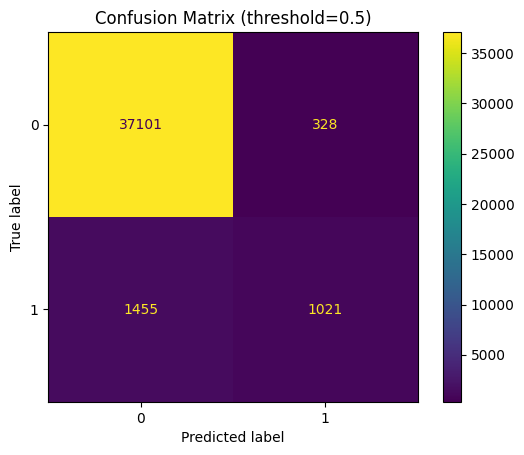

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

best = gb
ConfusionMatrixDisplay.from_predictions(y_test, best.predict(X_test))
plt.title("Confusion Matrix (threshold=0.5)")
plt.show()


At the default 0.5 threshold, the model captures most high-income individuals (high recall) but at the cost of a higher number of false positives, reflecting a recall-oriented decision boundary suitable for broad marketing outreach.

#### Final Model: Gradient Boosting

- Best F1-score → strongest balance between precision and recall
- High PR-AUC (0.65+), which is crucial for imbalanced data
- Much higher precision than XGBoost (fewer false positives)
- More interpretable and stable than XGBoost for a business client

***Business interpretation:***
- Better when marketing budgets matter
- Reduces wasted spend on low-income individuals incorrectly targeted as high-income
- More suitable for targeted or cost-sensitive campaigns

**Process fulfillment:**

We trained Logistic Regression (baseline) and three tree-based classifiers (Random Forest, Gradient Boosting, XGBoost) using a preprocessing pipeline with one-hot encoding for categorical variables and standard scaling for numeric variables. We performed a stratified 80/20 train-test split and evaluated models using ROC-AUC, precision, recall, and F1 due to class imbalance. Results remained stable after reducing the feature set, indicating most predictive signal is captured by core demographic, employment, household, and investment-related variables.